# 0. Preâmbulo 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import (SeasonalNaive, AutoARIMA, AutoETS, Naive)
from datasetsforecast.losses import (mae, mape, mse, mase, rmse, smape)
from tqdm.autonotebook import tqdm

c:\Users\Maria Inês\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# 1. Importação dos dados intermédios

In [3]:
df_grouped = pd.read_csv('Dados_intermedios/df_nb1.csv')
df_grouped = df_grouped.set_index('index')
df_grouped.columns

Index(['10.1 - Anti-histamínicos H1 sedativos e não sedativos',
       '12.2.5 - Sódio', '14.1.1 - Descongestionantes',
       '14.1.2 - Corticosteróides',
       '15.2.3 - Outros anti-inflamatórios, descongestionantes e antialérgicos',
       '5.2.3 - Associações e medicamentos descongestionantes'],
      dtype='object')

# 2. Pré-processamento das séries temporais


In [4]:
Y_df = (df_grouped
        .reset_index()
        .rename(columns={'index':'ds', 
                         '10.1 - Anti-histamínicos H1 sedativos e não sedativos':'anti_histaminicos', 
                         '12.2.5 - Sódio':'sodio',
                         '14.1.1 - Descongestionantes':'descongestionantes',                        
                         '14.1.2 - Corticosteróides':'corticosteroides',
                         '15.2.3 - Outros anti-inflamatórios, descongestionantes e antialérgicos':'outros',
                         '5.2.3 - Associações e medicamentos descongestionantes':'associacoes'                          
                        }) 
        )
Y_df.columns.name = None
Y_df = pd.melt(Y_df, id_vars=['ds'])
Y_df = (Y_df
        .rename(columns={'variable':'unique_id', 
                            'value':'y'})
        .filter(['unique_id', 'ds', 'y'])
        )

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df

,unique_id,ds,y
0,anti_histaminicos,2013-01-01,159.38
1,anti_histaminicos,2013-02-01,148.18
2,anti_histaminicos,2013-03-01,197.17
3,anti_histaminicos,2013-04-01,151.48
4,anti_histaminicos,2013-05-01,284.93
...,...,...,...
733,associacoes,2022-11-01,0.00
734,associacoes,2022-12-01,0.00
735,associacoes,2023-01-01,0.00
736,associacoes,2023-02-01,0.00


In [5]:
print(Y_df.dtypes)

unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object


In [6]:
# Substituir NaN por 0
Y_df = Y_df.fillna(0)

In [7]:
# mudar os nomes das colunas
df = Y_df[Y_df['unique_id'].isin(['anti_histaminicos', 'sodio', 'descongestionantes', 'corticosteroides', 'outros', 'associacoes' ])]

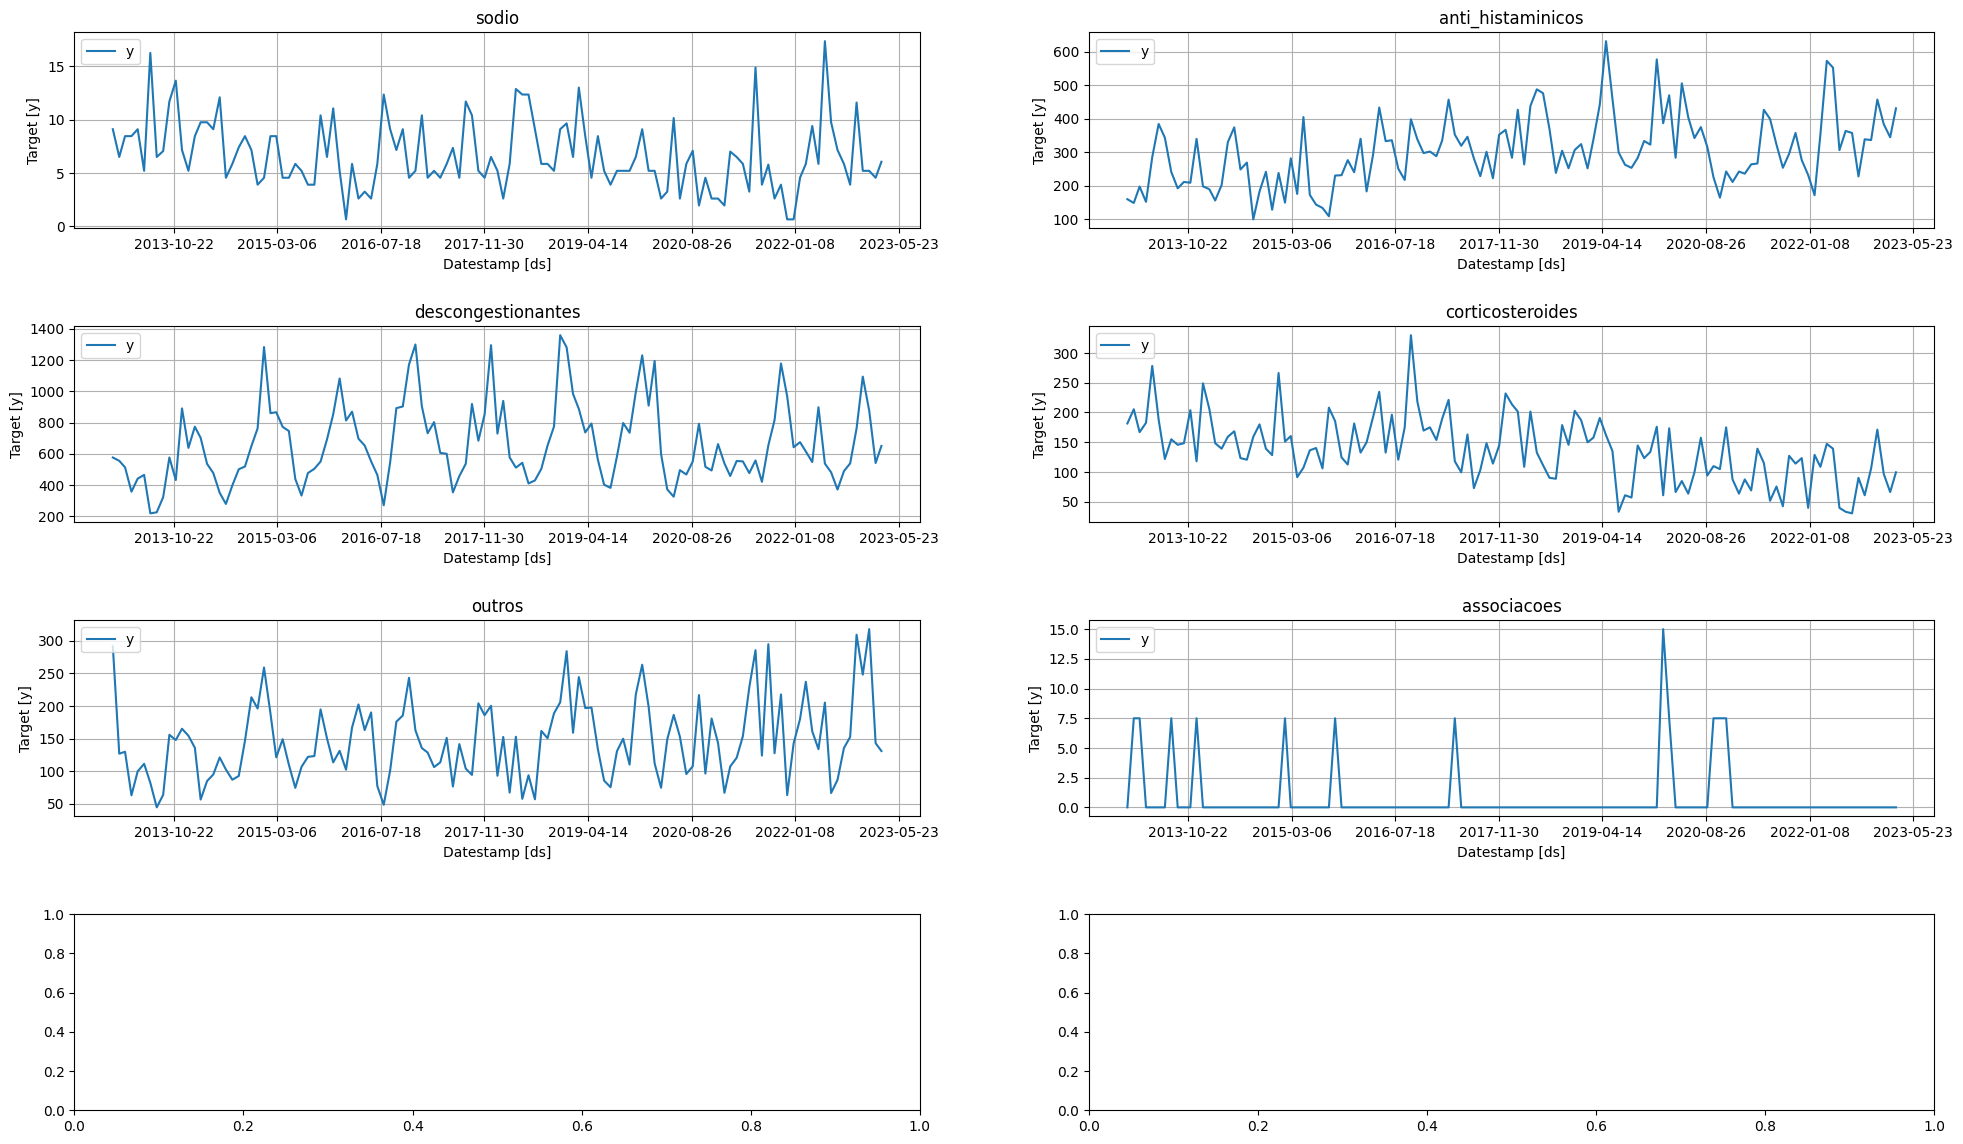

In [8]:
StatsForecast.plot(df)

# 3. Lista de modelos a testar

In [9]:
model_list = [
            Naive(),
            SeasonalNaive(season_length=12),
            AutoETS(season_length=12),
            AutoARIMA(season_length=12),
            AutoARIMA(d=0, season_length=12, alias='ARIMA_D0'), 
            AutoARIMA(d=1, season_length=12, alias='ARIMA_D1')
            ]

sf = StatsForecast(df=Y_df, 
                   models=model_list, 
                   freq='M',
                   n_jobs=-1,
                   fallback_model = SeasonalNaive(season_length=12))


# 4. Avaliação da performance

In [10]:
crossvalidation_df = sf.cross_validation(
    df = df,
    h = 1,
    step_size = 1,
    n_windows = 24
  )

crossvalidation_df

,ds,cutoff,y,Naive,SeasonalNaive,AutoETS,AutoARIMA,ARIMA_D0,ARIMA_D1
unique_id,,,,,,,,,
anti_histaminicos,2021-03-31,2021-02-28,263.480011,235.559998,283.130005,261.762329,274.986908,262.281921,274.986908
anti_histaminicos,2021-04-30,2021-03-31,265.980011,263.480011,505.350006,370.742554,321.933716,368.536469,321.933716
anti_histaminicos,2021-05-31,2021-04-30,426.350006,265.980011,404.079987,305.376190,295.568573,257.421783,295.568573
anti_histaminicos,2021-06-30,2021-05-31,399.059998,426.350006,342.049988,283.515961,317.280365,244.340744,317.280365
anti_histaminicos,2021-07-31,2021-06-30,322.579987,399.059998,374.690002,261.563385,337.912933,367.312775,337.912933
...,...,...,...,...,...,...,...,...,...
sodio,2022-10-31,2022-09-30,11.600000,3.900000,3.900000,6.365834,4.296488,4.296488,5.808101
sodio,2022-11-30,2022-10-31,5.200000,11.600000,0.650000,7.017011,8.461188,8.461188,8.373729
sodio,2022-12-31,2022-11-30,5.200000,5.200000,0.650000,6.759550,7.583453,7.583453,6.154587


In [11]:
# fig, ax = plt.subplots(1, 1, figsize=(12,6)) 
# ax.plot(Y_df.query('unique_id == "analg_antip"').set_index('ds').y, marker='.')
# ax.plot(crossvalidation_df.query('unique_id == "analg_antip"').filter(['ds','SeasonalNaive']).set_index('ds'))

# plt.show()

In [12]:
# fig, ax = plt.subplots(1, 1, figsize=(12,6)) 
# ax.plot(Y_df.query('unique_id == "analg_antip"').set_index('ds').y, marker='.')
# ax.plot(crossvalidation_df.query('unique_id == "analg_antip"').filter(['ds','AutoARIMA', 'AutoETS']).set_index('ds'))

# plt.show()

In [13]:
# fig, ax = plt.subplots(1, 1, figsize=(12,6)) 
# ax.plot(Y_df.query('unique_id == "analg_antip"').set_index('ds').y, marker='.')
# ax.plot(crossvalidation_df.query('unique_id == "analg_antip"').filter(['ds','AutoETS']).set_index('ds'))

# plt.show()

In [14]:
# crossvalidation_df.query('unique_id == "analg_antip"').filter(['ds','y','SeasonalNaive']).set_index('ds').plot()

### 5.1.1 Medidas de Exatidão


In [15]:
ts = crossvalidation_df.query('unique_id == "anti_histaminicos"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "anti_histaminicos"').reset_index()['SeasonalNaive']
f2 = crossvalidation_df.query('unique_id == "anti_histaminicos"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "anti_histaminicos"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "anti_histaminicos"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "anti_histaminicos"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[4:])
eval


,rmse,mae,mape
SeasonalNaive,132.217194,100.769997,28.085479
AutoETS,94.078468,70.868416,20.797043
AutoARIMA,97.082504,74.371773,21.885288
ARIMA_D0,111.294586,85.436455,24.376540
ARIMA_D1,97.082504,74.371773,21.885288


In [16]:
ts = crossvalidation_df.query('unique_id == "descongestionantes"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "descongestionantes"').reset_index()['SeasonalNaive']
f2 = crossvalidation_df.query('unique_id == "descongestionantes"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "descongestionantes"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "descongestionantes"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "descongestionantes"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[4:])
eval

,rmse,mae,mape
SeasonalNaive,230.790604,166.088745,23.138042
AutoETS,202.611084,153.921890,22.911774
AutoARIMA,224.274765,171.060974,25.916639
ARIMA_D0,199.458145,136.929642,19.979312
ARIMA_D1,227.101685,173.208572,26.066756


In [17]:
ts = crossvalidation_df.query('unique_id == "outros"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "outros"').reset_index()['Naive']
f2 = crossvalidation_df.query('unique_id == "outros"').reset_index()['SeasonalNaive']
f3 = crossvalidation_df.query('unique_id == "outros"').reset_index()['AutoETS']
f4 = crossvalidation_df.query('unique_id == "outros"').reset_index()['AutoARIMA']
f5 = crossvalidation_df.query('unique_id == "outros"').reset_index()['ARIMA_D0']
f6 = crossvalidation_df.query('unique_id == "outros"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5), rmse(ts, f6)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5), mae(ts, f6)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5), mape(ts, f6)],
}, index=crossvalidation_df.columns[3:])
eval

,rmse,mae,mape
Naive,98.866699,82.168755,58.429509
SeasonalNaive,109.547310,88.964577,60.337800
AutoETS,77.661583,59.178146,40.274772
AutoARIMA,92.150307,79.200180,53.148526
ARIMA_D0,94.647003,81.517906,54.875904
ARIMA_D1,78.038857,65.219170,43.199679


In [18]:
ts = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['Naive']
f2 = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['SeasonalNaive']
f3 = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['AutoETS']
f4 = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['AutoARIMA']
f5 = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['ARIMA_D0']
f6 = crossvalidation_df.query('unique_id == "corticosteroides"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5), rmse(ts, f6)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5), mae(ts, f6)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5), mape(ts, f6)],
}, index=crossvalidation_df.columns[3:])
eval

,rmse,mae,mape
Naive,51.675182,42.739582,57.380706
SeasonalNaive,49.088943,42.449997,61.341655
AutoETS,45.092846,37.347687,61.073005
AutoARIMA,42.046425,35.515034,55.821627
ARIMA_D0,47.823593,38.275913,53.103811
ARIMA_D1,42.046425,35.515034,55.821627


In [20]:
ts = crossvalidation_df.query('unique_id == "sodio"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "sodio"').reset_index()['Naive']
f2 = crossvalidation_df.query('unique_id == "sodio"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "sodio"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "sodio"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "sodio"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[np.array([3,5,6,7,8])])
eval

,rmse,mae,mape
Naive,5.149592,3.727917,76.433581
AutoETS,4.078119,2.856580,90.946490
AutoARIMA,4.301630,3.159496,99.937266
ARIMA_D0,4.465889,3.415166,104.211795
ARIMA_D1,4.106833,2.859998,96.802491


In [22]:
ts = crossvalidation_df.query('unique_id == "associacoes"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "associacoes"').reset_index()['Naive']
f2 = crossvalidation_df.query('unique_id == "associacoes"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "associacoes"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "associacoes"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "associacoes"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[np.array([3,5,6,7,8])])
eval

,rmse,mae,mape
Naive,0.000000,0.000000,0.0
AutoETS,0.936025,0.918008,0.0
AutoARIMA,0.000000,0.000000,0.0
ARIMA_D0,0.000000,0.000000,0.0
ARIMA_D1,0.695551,0.689889,0.0


In [23]:
crossvalidation_df.to_csv('crossvalidationAH.csv')

## 5.2. Ajustar o modelo

In [ ]:
#AutoARIMA1 =[AutoARIMA(season_length=12)]

#AutoARIMA1_sf = StatsForecast(df=df, models=AutoARIMA1, freq='M')

In [ ]:
# forecasts_AutoARIMA1 = AutoARIMA1_sf.forecast(h=1, fitted=True)

# forecasts_AutoARIMA1



In [ ]:
# sf.plot(df, forecasts_AutoARIMA1)

In [ ]:
# insample_df =  AutoARIMA1_sf.forecast_fitted_values()
# insample_df

In [ ]:
# sf.plot(insample_df)

In [ ]:
# Previsão com os intervalos de confiança
# fctlevel_df = AutoARIMA1_sf.forecast(h=1, level=[80, 95])  
# fctlevel_df

In [ ]:
# col_list = ['ds','AutoARIMA','AutoARIMA-lo-95','AutoARIMA-lo-80','AutoARIMA-hi-80','AutoARIMA-hi-95']

# sf.plot(Y_df, fctlevel_df.filter(col_list), level=[80, 95])

## Resíduos

In [ ]:
# from statsforecast.arima import arima_string
# AutoARIMA1_sf.fit()
# arima_string(AutoARIMA1_sf.fitted_[0,0].model_)

In [ ]:
# result=AutoARIMA1_sf.fitted_[0,0].model_
# print(result.keys())
# print(result['arma'])

In [ ]:
# residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
# residual

In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=2)

# # plot[1,1]
# residual.plot(ax=axs[0,0])
# axs[0,0].set_title("Residuals");

# # plot
# sns.distplot(residual, ax=axs[0,1]);
# axs[0,1].set_title("Density plot - Residual");

# # plot
# stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
# axs[1,0].set_title('Plot Q-Q')

# # plot
# plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
# axs[1,1].set_title("Autocorrelation");

# plt.show();



# Modelo de Teste


In [ ]:
# rmse = rmse(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
# print("RMSE using cross-validation: ", rmse)

In [ ]:
# def evaluate_performace(y_hist, y_true, model):
#     evaluation = {}
#     evaluation[model] = {}
#     for metric in [mase, mae, mape, rmse, smape]:
#         metric_name = metric.__name__
#         if metric_name == 'mase':
#             evaluation[model][metric_name] = metric(y_true['y'].values, 
#                                                 y_true[model].values, 
#                                                 y_hist['y'].values, seasonality=12)
#         else:
#             evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
#     return pd.DataFrame(evaluation).T